# **FEDERAL UNIVERSITY OF RIO GRANDE DO NORTE**
## **ALGORITHMS AND DATA STRUCTURES II**

### **Instructor:**

1. Ivanovitch Medeiros Dantas da Silva

### **Students:**

1. André Eduardo Meneses do Nascimento
2. Matheus Gomes Diniz Andrade

# Installing Libraries

# Import Libraries

In [1]:
import numpy  as np
import pandas as pd

import networkx as nx

In [2]:
import matplotlib.pyplot as plt
import seaborn           as sns

# Notebook Patterns

In [3]:
plot = {
  "size": (18, 6),
  "title_size": 20,
  "title_color": "#262626",
  "subtitle_size": 16,
  "subtitle_color": "#868586",
}

# Data Aquisition

In [4]:
!gdown "https://raw.githubusercontent.com/alvarofpp/dataset-flights-brazil/main/data/air_traffic.graphml"

Downloading...
From: https://raw.githubusercontent.com/alvarofpp/dataset-flights-brazil/main/data/air_traffic.graphml
To: /content/air_traffic.graphml
999kB [00:00, 65.9MB/s]        


In [5]:
file_path = "air_traffic.graphml"

G = nx.read_graphml(file_path)

# Exploratory Analysis

Number of nodes in the network

In [6]:
G.number_of_nodes()

1083

Number of edges in the network

In [7]:
G.number_of_edges()

9613

## Assortativity

Assortativity is a metric that describes the tendency of similar nodes be connected.

- Assortativity $\rightarrow$ 1:

  **Assortative network**. In this case, nodes with similar degrees have a tendency to connect withtrad each other.

- Assortativity $\rightarrow$ 0:

  **Neutral network**. In this case, nodes don't have preference to connect.

- Assortativity $\rightarrow$ -1:

  **Disassortative network**. In this case, nodes with different degrees have a tendency to connect withtrad each other.
  

#### Data preprocessing

Since the nodes do not contain an attribute with the region information, we must provide it by using the 'airports.csv' file.

In [47]:
!gdown "https://raw.githubusercontent.com/alvarofpp/dataset-flights-brazil/main/data/airports.csv"

airports = pd.read_csv('airports.csv')
brazilian_airports = airports[airports['country'] == 'BRASIL']

brazilian_nodes = [n for n, attr in G.nodes(data=True) if attr.get('country') == 'BRASIL']
brazil_subgraph = G.subgraph(brazilian_nodes)

brazilian_airports.set_index('code', inplace=True)

for node in brazil_subgraph.nodes():
  brazil_subgraph.nodes[node]['region'] = brazilian_airports.loc[node, 'region']


Downloading...
From: https://raw.githubusercontent.com/alvarofpp/dataset-flights-brazil/main/data/airports.csv
To: /content/airports.csv
87.6kB [00:00, 87.8MB/s]       


In [ ]:
for node in G.nodes():
    node_attrs = G.nodes[node]
    print(f"Node {node}:")
    for attr, value in node_attrs.items():
        print(f" - {attr}: {value}")

for edge in G.edges():
    u, v = edge
    edge_attrs = G.edges[u, v]
    print(f"Edge ({u}, {v}):")
    for attr, value in edge_attrs.items():
        print(f" - {attr}: {value}")

We can now proceed with the assortativity computation

In [28]:
nx.attribute_assortativity_coefficient(brazil_subgraph,"region")


0.36728130173582757

A close-to-zero assortativity value indicates that there is no significant tendency for nodes within the same region to preferentially connect with each other. In other words, there is a higher number of links between nodes in different regions.

This observation is expected since most flights connect various parts of the country to the major hubs, São Paulo and Rio de Janeiro. The brazilian flight network converge to a star topology. 

### Interactive Plot

In [55]:
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Create a mapping dictionary for region colors
region_colors = {
    'NORDESTE': 'red',
    'SUDESTE': 'blue',
    'CENTRO-OESTE': 'green',
    'SUL': 'purple',
    'NORTE': 'orange',
}

# Extract node attributes
positions = {node: (data['longitude'], data['latitude']) for node, data in brazil_subgraph.nodes(data=True)}
regions = nx.get_node_attributes(brazil_subgraph, 'region')


edge_trace = go.Scattergeo(
    locationmode='country names',
    lon=[positions[edge[0]][0] for edge in brazil_subgraph.edges()],
    lat=[positions[edge[0]][1] for edge in brazil_subgraph.edges()],
    mode='lines',
    line=dict(width=1, color='gray'),
)

node_trace = go.Scattergeo(
    locationmode='country names',
    lon=[data['longitude'] for node, data in brazil_subgraph.nodes(data=True)],
    lat=[data['latitude'] for node, data in brazil_subgraph.nodes(data=True)],
    text=[data['name'] for node, data in brazil_subgraph.nodes(data=True)],
    mode='markers',
    marker=dict(
        size=8,
        color=[region_colors[regions[node]] for node in brazil_subgraph.nodes()],
        colorscale='Viridis',
        colorbar=dict(title='Region'),
        opacity=0.8,
    ),
)

fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(
    title='Interactive Graph - Brazil',
    showlegend=False,
    geo=dict(showland=False, showcoastlines=False),
)
fig.show()


### Static Plot

In [ ]:
assortativity = nx.degree_assortativity_coefficient(G)

In [ ]:
assortativity

-0.26968698005247493

In [ ]:
network_degrees = pd.DataFrame()

In [ ]:
for node_info in zip(list(G.nodes), dict(nx.degree(G)).values(), nx.average_neighbor_degree(G).values()):
  new_line = pd.DataFrame({
    "Self Degree": node_info[1],
    "Mean Neigh Degree": np.round(node_info[2], 2)
  }, index=[node_info[0]])

  network_degrees = pd.concat([
    network_degrees,
    new_line
  ])

In [ ]:
network_degrees.head()

,Self Degree,Mean Neigh Degree
KDFW,35,100.00
KJFK,54,105.39
KMIA,194,53.40
SBCF,261,51.26
SBGL,401,37.71


In [ ]:




# ax.set_ylabel("CO₂ (g)", fontsize=16)# Configuração dos dados
# network_degrees = pd.DataFrame({
#     "Self Degree": [1, 2, 3, 4, 5],
#     "Mean Neigh Degree": [2, 3, 4, 5, 6]
# })
# ax.set_xlabel("Tempo (s)", fontsize=16)

# ax.plot(cumsum_gasoline_17_08_2022, color=graph_colors["black"])
# ax.plot(cumsum_ethanol_27_02_2023, color=graph_colors["blue"])

# plt.text(1799, cumsum_gasoline_17_08_2022.iloc[-1], "Gasolina", weight="bold", fontsize=14)
# plt.text(1799, cumsum_ethanol_27_02_2023.iloc[-1], "Etanol", weight="bold", fontsize=14)

# plt.text(1799, cumsum_gasoline_17_08_2022.iloc[-1] - 100, cumsum_gasoline_17_08_2022.iloc[-1].round(2), weight="bold", fontsize=14)
# plt.text(1799, cumsum_ethanol_27_02_2023.iloc[-1] - 100, cumsum_ethanol_27_02_2023.iloc[-1].round(2), weight="bold", fontsize=14)

# plt.text(0, 2900, "CO₂ - Soma Acumulada", fontsize=18, color=text_colors["title"], weight="bold")
# plt.text(0, 2750, "Comparativo entre Gasolina e Etanol", fontsize=14, color=text_colors["subtitle"])

# plt.show()

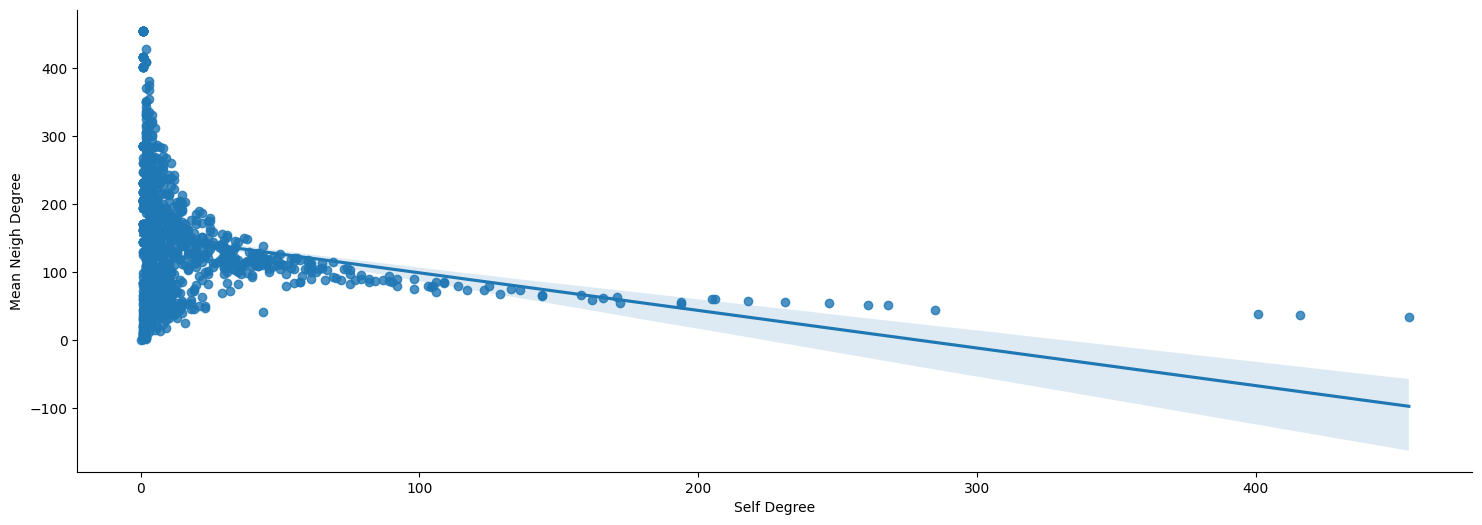

In [ ]:
fig, ax = plt.subplots(figsize=plot["size"])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax = sns.regplot(data=network_degrees, x="Self Degree", y="Mean Neigh Degree")

plt.show()

In [ ]:
higher_self_degree_idx = network_degrees["Self Degree"].argmax()
lower_self_degree_idx  = network_degrees["Self Degree"].argmin()

higher_mean_neigh_degree_idx = network_degrees["Mean Neigh Degree"].argmax()
lower_mean_neigh_degree_idx  = network_degrees["Mean Neigh Degree"].argmin()


higher_self_degree = network_degrees.iloc[higher_self_degree_idx]
lower_self_degree  = network_degrees.iloc[lower_self_degree_idx]

higher_mean_neigh_degree = network_degrees.iloc[higher_mean_neigh_degree_idx]
lower_mean_neigh_degree  = network_degrees.iloc[lower_mean_neigh_degree_idx]

In [ ]:
network_degrees.iloc[9]

Self Degree          0.0
Mean Neigh Degree    0.0
Name: nan, dtype: float64

In [ ]:
network_degrees["Self Degree"].argmin()

9

In [ ]:
network_degrees["Mean Neigh Degree"].argmin()

9

In [ ]:
network_degrees.iloc[lower_self_degree_idx, :]

Self Degree          0.0
Mean Neigh Degree    0.0
Name: nan, dtype: float64

In [ ]:
print(f"higher_self_degree: {higher_self_degree.name}")
print(f"lower_self_degree: {lower_self_degree.name}")
print(f"higher_mean_neigh_degree: {higher_mean_neigh_degree.name}")
print(f"lower_mean_neigh_degree: {lower_mean_neigh_degree.name}")

higher_self_degree: SBGR
lower_self_degree: nan
higher_mean_neigh_degree: MDLR
lower_mean_neigh_degree: nan


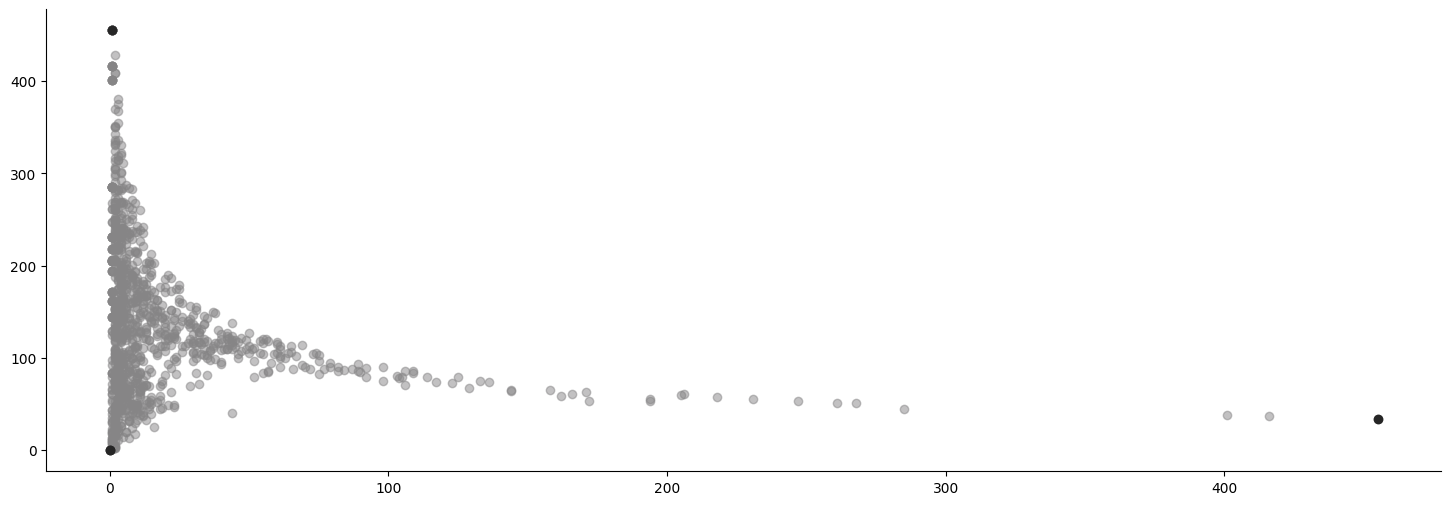

In [ ]:
fig, ax = plt.subplots(figsize=plot["size"])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.scatter(data=network_degrees, x="Self Degree", y="Mean Neigh Degree", color="#868586", alpha=0.5)


ax.scatter(x=higher_self_degree["Self Degree"], y=higher_self_degree["Mean Neigh Degree"], color="#262626")
ax.scatter(x=lower_self_degree["Self Degree"], y=lower_self_degree["Mean Neigh Degree"], color="#262626")

ax.scatter(x=higher_mean_neigh_degree["Self Degree"], y=higher_mean_neigh_degree["Mean Neigh Degree"], color="#262626")
ax.scatter(x=lower_mean_neigh_degree["Self Degree"], y=lower_mean_neigh_degree["Mean Neigh Degree"], color="#262626")

plt.show()

In [ ]:
G.nodes["KDFW"]

{'name': 'DALLAS & FORT WORTH, TEXAS',
 'country': 'ESTADOS UNIDOS DA AMÉRICA',
 'latitude': '32.896801',
 'longitude': '-97.038002'}